# Downloade

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/people-clothing-segmentation/labels (1).csv
/kaggle/input/people-clothing-segmentation/labels.csv
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0079.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0780.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0866.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0645.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0072.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0526.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0138.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0068.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0049.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0362.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0748.png
/kaggle/input/people-clothing-segmentation/png_images/IMAGES/img_0286.png


In [ ]:
import os
import cv2
from glob import glob
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Conv2DTranspose,Concatenate,Input,Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
image_paths=sorted(glob('/kaggle/input/people-clothing-segmentation/png_images/IMAGES/*'))
mask_paths=sorted(glob('/kaggle/input/people-clothing-segmentation/png_masks/MASKS/*'))

In [ ]:
def data_sort(imag):
    image = []

    for x in range(len(imag)):
        q = cv2.imread(imag[x])
        q = cv2.resize(q,(256,256))
        q = q/255.
        image.append(q)
    return image

In [ ]:
dress = data_sort(image_paths)
mask = data_sort(mask_paths)

In [ ]:
z = np.array(dress)
y = np.array(mask)

In [ ]:
z.shape

(1000, 256, 256, 3)

In [ ]:
y.shape

(1000, 256, 256, 3)

(800, 256, 256, 3)

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(z,y, test_size=0.2, random_state=42)

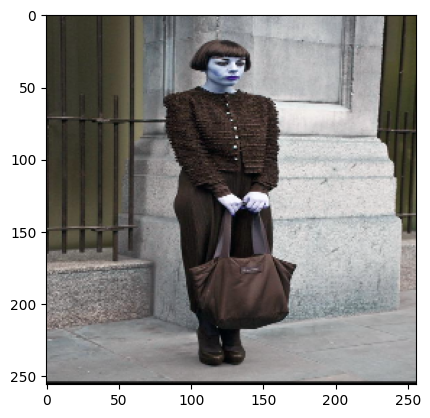

In [ ]:
plt.imshow(x_train[64])

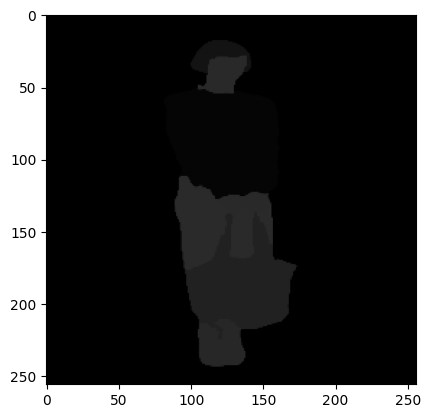

In [ ]:
plt.imshow(y_train[64])

# Model********

In [ ]:
def conv_block(inputs,num_filters):
    x = Conv2D(num_filters,3,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(num_filters,3,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:

def encoder(inputs,num_filters):
    x = conv_block(inputs,num_filters)
    p = MaxPool2D((2,2))(x)

    return x,p

In [ ]:
def decoder(inputs,skip_features,num_filters):
    x = Conv2DTranspose(num_filters,(2,2),strides=2,padding='same')(inputs)
    x = Concatenate()([x,skip_features])
    x = conv_block(x,num_filters)

    return x

In [ ]:
def unet(input_shape):
    inputs = Input(input_shape)

    # encoders
    s0,p0 = encoder(inputs,32)
    s1,p1 = encoder(p0,64)   # p = 256
    s2,p2 = encoder(p1,128)      # p = 128
    s3,p3 = encoder(p2,256)      # p = 64
    s4,p4 = encoder(p3,512)      # p = 32

    # Bridge
    b1 = conv_block(p4,1024)

    #decoder

    d1 = decoder(b1,s4,512)      # p = 32
    d2 = decoder(d1,s3,256)      # p = 64
    d3 = decoder(d2,s2,128)      # p = 128
    d4 = decoder(d3,s1,64)       # p = 256
    d5 = decoder(d4,s0,32)

    #output

    outputs = Conv2D(3,(1,1),padding="same",activation = "sigmoid")(d5)

    model = Model(inputs,outputs,name='U-Net')

    return model

In [ ]:
input_shape = (256,256,3)
model = unet(input_shape=input_shape)

In [ ]:
model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_193 (Conv2D)         (None, 256, 256, 32)         896       ['input_13[0][0]']            
                                                                                                  
 batch_normalization_181 (B  (None, 256, 256, 32)         128       ['conv2d_193[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_181 (Activation  (None, 256, 256, 32)         0         ['batch_normalization_181[

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=30
)

Epoch 1/30
25/25 [==============================] - 21s 483ms/step - loss: 0.0819 - accuracy: 0.9914 - val_loss: 0.1005 - val_accuracy: 0.9836
Epoch 2/30
25/25 [==============================] - 12s 469ms/step - loss: 0.0821 - accuracy: 0.9916 - val_loss: 0.0836 - val_accuracy: 1.0000
Epoch 3/30
25/25 [==============================] - 12s 474ms/step - loss: 0.0820 - accuracy: 0.9926 - val_loss: 0.0835 - val_accuracy: 1.0000
Epoch 4/30
25/25 [==============================] - 12s 471ms/step - loss: 0.0823 - accuracy: 0.9966 - val_loss: 0.0833 - val_accuracy: 0.9994
Epoch 5/30
25/25 [==============================] - 12s 462ms/step - loss: 0.0822 - accuracy: 0.9977 - val_loss: 0.0853 - val_accuracy: 0.9999
Epoch 6/30
25/25 [==============================] - 12s 460ms/step - loss: 0.0820 - accuracy: 0.9968 - val_loss: 0.0866 - val_accuracy: 1.0000
Epoch 7/30
25/25 [==============================] - 12s 461ms/step - loss: 0.0809 - accuracy: 0.8678 - val_loss: 0.0858 - val_accuracy: 0.9984

In [ ]:
zzzz = model.predict(test_set)

7/7 [==============================] - 1s 134ms/step


In [ ]:
test_set[7]

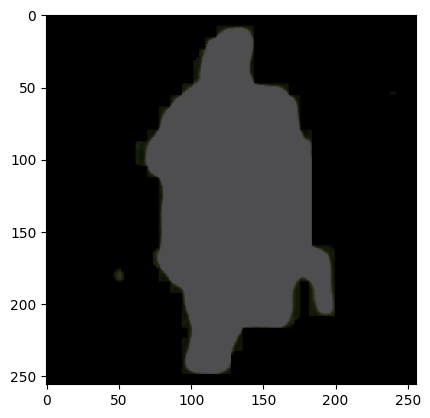

In [ ]:
plt.imshow(zzzz[12])

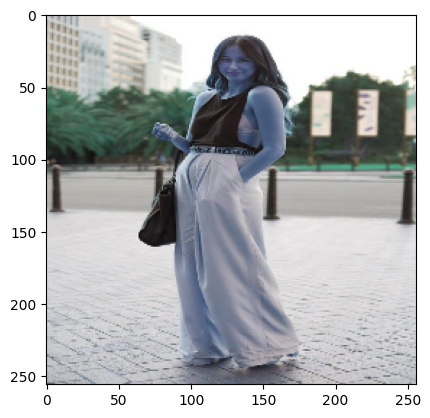

In [ ]:
plt.imshow(x_test[1])

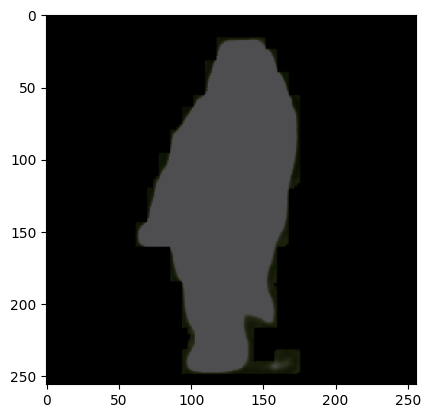

In [ ]:
plt.imshow(zzzz[1])

In [ ]:
z = y_train.reshape(-1, 1)

In [ ]:
z.shape

(157286400, 1)

In [ ]:
2097152*3

6291456

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Example labels and logits
labels = [0, 1, 2, 1, 0]
logits = [[0.9, 0.1, 0.1], [0.2, 0.7, 0.1], [0.1, 0.2, 0.7], [0.2, 0.8, 0.1], [0.8, 0.1, 0.1]]

# One-hot encode labels
labels_one_hot = to_categorical(labels, num_classes=3)

# Now labels_one_hot and logits should have compatible shapes


In [ ]:
labels_one_hot.shape

(5, 3)

In [ ]:
512*512*3

786432

In [ ]:
z.shape

(1000, 256, 256, 3)

In [ ]:
y.shape

(1000, 256, 256, 3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
IMAGE_SHAPE = (256,256)
BATCH_SIZE = 32
data_gen = ImageDataGenerator()

train_set = data_gen.flow(
    x = x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_set = data_gen.flow(
    x = x_test,
    y=y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)



In [ ]:
train_set